# 3. Series de retornos

## Convirtiendo precios a retornos

Existen dos tipos de retornos:

* **Retornos simples:** $$R_t = \frac{(P_t - P_{t-1})}{P_{t-1}} = \frac{P_t}{P_{t-1}}-1$$ En Pandas, se puede calcular usando el método `pct_change()`. Ejemplo:


In [1]:
import pandas as pd
import yfinance as yf

df = yf.download("NVDA", start = "2020-01-01", end = "2025-10-20", auto_adjust=True, multi_level_index=False)
df = df.loc[:, ["Close"]]
df.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2020-01-02,5.971410
2020-01-03,5.875831
2020-01-06,5.900473
2020-01-07,5.971908
2020-01-08,5.983109


In [2]:
df["simple_rtn"] = df["Close"].pct_change()
df.head()

,Close,simple_rtn
Date,,
2020-01-02,5.971410,NaN
2020-01-03,5.875831,-0.016006
2020-01-06,5.900473,0.004194
2020-01-07,5.971908,0.012107
2020-01-08,5.983109,0.001876


* **Retornos en logaritmos:** $$r_i = \ln \left(\frac{P_t}{P_{t-1}}\right) = \ln(P_t) - \ln(P_{t-1})$$ Para calcular estos retornos deberemos usar Numpy

In [3]:
import numpy as np

df["log_rtn"] = np.log(df["Close"] / df["Close"].shift(1))
df.head()

,Close,simple_rtn,log_rtn
Date,,,
2020-01-02,5.971410,NaN,NaN
2020-01-03,5.875831,-0.016006,-0.016136
2020-01-06,5.900473,0.004194,0.004185
2020-01-07,5.971908,0.012107,0.012034
2020-01-08,5.983109,0.001876,0.001874


Gráficamente:

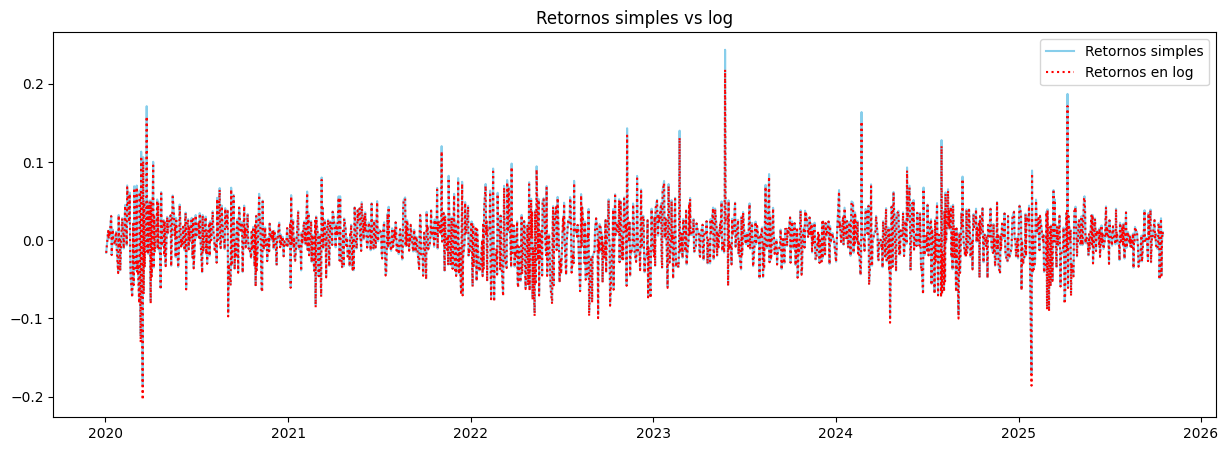

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df.iloc[:,1], color = "skyblue", label = "Retornos simples")
plt.plot(df.iloc[:,2], color = "red", label = "Retornos en log", linestyle='dotted')
plt.title("Retornos simples vs log")
plt.legend()
plt.show()

Los **retornos simples** expresan el cambio porcentual entre dos precios y se interpretan directamente como la ganancia o pérdida en un periodo, siendo ideales para reportes financieros o comparaciones entre activos. Sin embargo, no pueden sumarse en el tiempo y pueden distorsionar los resultados cuando las variaciones son grandes.

Por otro lado, los **retornos logarítmicos** calculan el logaritmo del cociente entre precios consecutivos, representando el crecimiento de manera continua; esto los hace aditivos y más adecuados para análisis estadísticos, modelamiento financiero y estudios de series temporales, ya que permiten trabajar con distribuciones más simétricas y se aproximan a los simples cuando los cambios de precio son pequeños.

En general, los simples se usan para comunicación y análisis práctico, mientras que los logarítmicos son preferidos en contextos analíticos o cuantitativos.

## Ajuste de retornos por inflación

El efecto Fisher permite convertir un retorno nominal pasado en un retorno real, es decir, ajustado por la pérdida de poder adquisitivo causada por la inflación

 $$ r^{real}_t = \frac{1 + i_t}{1 + \pi_t} - 1$$ Donde:
* $r^{real}_t$ es el retorno real.
* $i_t$ es el retorno nominal.
* $\pi_t$ es la inflación.

Para el caso de EEUU, necesitaremos obtener la tasa de inflación de EEUU, para ello usaremos la librería *cpi*.

In [5]:
!pip install cpi --quiet
import cpi
cpi.update()

In [6]:
cpi_series = cpi.series.get()
df_cpi = cpi_series.to_dataframe()

df_cpi.head()

,series_id,year,date,value,period_id,period_code,period_abbreviation,period_name,period_month,period_type
0,CUUR0000SA0,1997,1997-01-01,159.1,M01,M01,JAN,January,1,monthly
1,CUUR0000SA0,1997,1997-02-01,159.6,M02,M02,FEB,February,2,monthly
2,CUUR0000SA0,1997,1997-03-01,160.0,M03,M03,MAR,March,3,monthly
3,CUUR0000SA0,1997,1997-04-01,160.2,M04,M04,APR,April,4,monthly
4,CUUR0000SA0,1997,1997-05-01,160.1,M05,M05,MAY,May,5,monthly


In [7]:
df_cpi_val = df_cpi.query("period_type == 'monthly' and year >=2020").loc[:, ["date", "value"]].set_index("date")
df_cpi_val.head(10)

,value
date,
2020-01-01,257.971
2020-02-01,258.678
2020-03-01,258.115
2020-04-01,256.389
2020-05-01,256.394
2020-06-01,257.797
2020-07-01,259.101
2020-08-01,259.918
2020-09-01,260.280


Este dato de inflación es a *final de mes*, pero al usar `cpi` nos lo indica a principio de mes. ¿Cómo convertirlo?

In [8]:
tmp_fecha = pd.to_datetime(df_cpi_val.index) + pd.offsets.MonthEnd()
df_cpi_val.index = tmp_fecha
df_cpi_val.head()

,value
date,
2020-01-31,257.971
2020-02-29,258.678
2020-03-31,258.115
2020-04-30,256.389
2020-05-31,256.394


Ajustemos el precio de la acción en términos mensuales (fin de mes):

In [9]:
df_2 = df.loc[:,["Close"]].resample("ME").last()
df_2.head()

,Close
Date,
2020-01-31,5.884792
2020-02-29,6.726119
2020-03-31,6.564983
2020-04-30,7.279262
2020-05-31,8.841806


Hacemos el join con inflación y calculamos retorno simple:

In [10]:
df_2 = df_2.join(df_cpi_val, how="inner")
df_2["retorno"] = df_2["Close"].pct_change()
df_2["inflacion"] = df_2["value"].pct_change()
df_2.head()

,Close,value,retorno,inflacion
2020-01-31,5.884792,257.971,NaN,NaN
2020-02-29,6.726119,258.678,0.142966,0.002741
2020-03-31,6.564983,258.115,-0.023957,-0.002176
2020-04-30,7.279262,256.389,0.108801,-0.006687
2020-05-31,8.841806,256.394,0.214657,0.000020


In [11]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2020-01-31 to 2025-08-31
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      68 non-null     float64
 1   value      68 non-null     float64
 2   retorno    67 non-null     float64
 3   inflacion  67 non-null     float64
dtypes: float64(4)
memory usage: 2.7 KB


Calculando retorno real:

In [12]:
df_2["Retorno Real"] = (df_2["retorno"] + 1)/(df_2["inflacion"] + 1) - 1
df_2.head()

,Close,value,retorno,inflacion,Retorno Real
2020-01-31,5.884792,257.971,NaN,NaN,NaN
2020-02-29,6.726119,258.678,0.142966,0.002741,0.139842
2020-03-31,6.564983,258.115,-0.023957,-0.002176,-0.021828
2020-04-30,7.279262,256.389,0.108801,-0.006687,0.116266
2020-05-31,8.841806,256.394,0.214657,0.000020,0.214633


Gráfico de retorno nominal vs real:

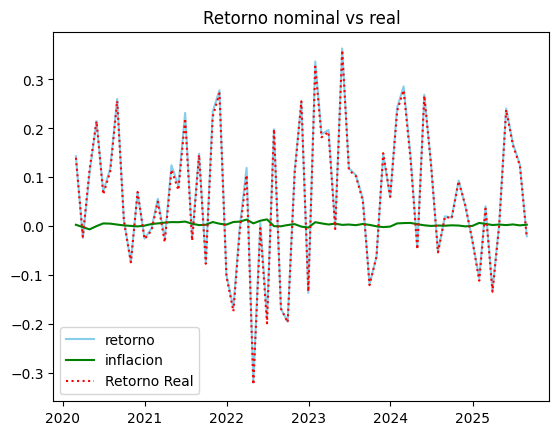

In [13]:
plt.plot(df_2["retorno"], data = df_2, color = "skyblue")
plt.plot(df_2["inflacion"], data = df_2, color = "green")
plt.plot(df_2["Retorno Real"], data = df_2, color = "red", linestyle='dotted')
plt.title("Retorno nominal vs real")
plt.legend()
plt.show()

## Detección de outliers

Una opción para detectar *outliers* es a través del **filtro de Hampel**. Este usa la desviación media absoluta (MAD) y la técnica de rolling para deterctar outliers. En específico, la respuesta de este filtro viene dado por:

$$y_k = \left\{ \begin{array}{ccc} x_k & si & |x_k - m_k| \leq S_k \\
m_k & si & |x_k - m_k| > S_k \end{array}\right.$$

donde $m_k$ es la mediana de la ventana tipo *rolling*, mientras que $S_k = 1.4826 \times MAD_t$.

Ejemplo:

In [14]:
!pip install sktime --quiet

In [15]:
import yfinance as yf
from sktime.transformations.series.outlier_detection import HampelFilter

# Usaremos precios de Tesla
df = yf.download("TSLA", start = "2020-01-01", end = "2025-10-20", auto_adjust=True, multi_level_index=False)
df = df.loc[:, ["Close"]]
df.head()
df["retorno"] = df["Close"].pct_change()
df.head()

[*********************100%***********************]  1 of 1 completed


,Close,retorno
Date,,
2020-01-02,28.684000,NaN
2020-01-03,29.534000,0.029633
2020-01-06,30.102667,0.019255
2020-01-07,31.270666,0.038801
2020-01-08,32.809334,0.049205


Aplicando filtro:

In [16]:
hampel = HampelFilter(window_length = 10, return_bool = True)
df["outlier"] = hampel.fit_transform(df["Close"])
df.head()

,Close,retorno,outlier
Date,,,
2020-01-02,28.684000,NaN,False
2020-01-03,29.534000,0.029633,False
2020-01-06,30.102667,0.019255,False
2020-01-07,31.270666,0.038801,False
2020-01-08,32.809334,0.049205,False


Gráfico:

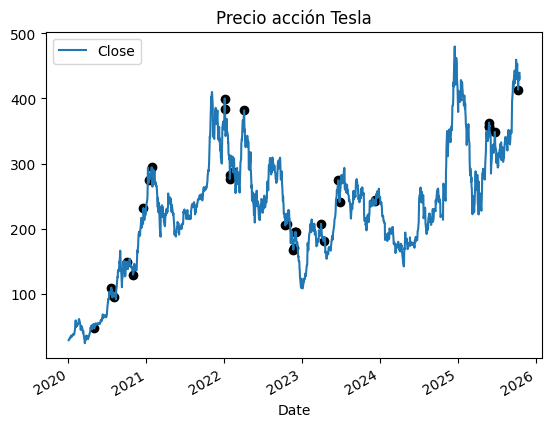

In [17]:
fig, ax = plt.subplots()

df[["Close"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier"]].index,
           df.loc[df["outlier"], "Close"],
           color = "black", label = "outliers")
ax.set_title("Precio acción Tesla")
plt.show()

Y en los retornos:

/usr/local/lib/python3.12/dist-packages/sktime/transformations/series/outlier_detection.py:96: UserWarning: Series contains nan values, more nan might be
                added if there are outliers
  return self._transform_series(Z)


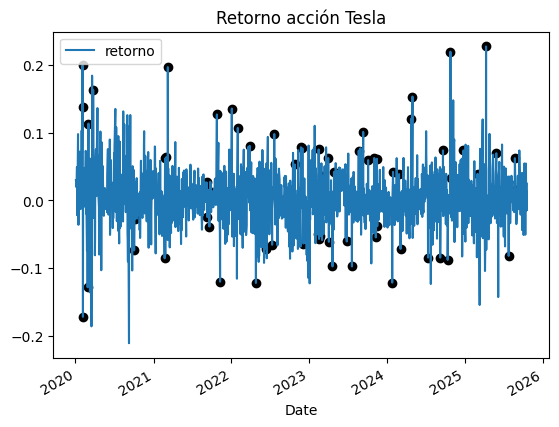

In [18]:
df["outlier ret"] = hampel.fit_transform(df["retorno"])

fig, ax = plt.subplots()

df[["retorno"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier ret"]].index,
           df.loc[df["outlier ret"], "retorno"],
           color = "black", label = "Outliers")
ax.set_title("Retorno acción Tesla")
plt.show()